In [4]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import datacommons_pandas as dc
import numpy as np
import math
import sklearn.metrics as skmetrics
from sklearn import linear_model, preprocessing
import lightgbm as lgbm

In [5]:
type(linear_model)

module

#### Setting Up the Embeddings

In [6]:
county_embeddings = pd.read_csv("v0/us/county_embeddings.csv").set_index('place')
zip_embeddings = pd.read_csv("v0/us/zcta_embeddings.csv").set_index('place')
embeddings = pd.concat([county_embeddings, zip_embeddings])

,state,county,city,population,latitude,longitude,feature0,feature1,feature2,feature3,...,feature320,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329
place,,,,,,,,,,,,,,,,,,,,,
zip/97910,OR,Malheur County,Jordan Valley,609,42.749076,-117.511459,-0.138227,1.120377,0.072900,0.297442,...,-0.158891,-0.168708,1.231994,-0.155765,3.043214,-0.169749,0.177463,-0.001661,-0.001010,4.495589
zip/89412,NV,Washoe County,Gerlach,98,41.102934,-119.695361,-0.141379,1.422782,0.234269,0.159156,...,-0.157417,-0.043606,2.788701,-0.062547,3.700745,-0.169827,-0.137990,-0.024385,-0.000295,3.399393
zip/88030,NM,Luna County,Deming,24139,32.191634,-107.729431,-0.046666,1.414424,0.146803,1.113256,...,-0.000654,0.437475,4.229295,0.229199,2.098469,1.150497,0.716122,-0.116499,-0.051163,3.866543
zip/82633,WY,Converse County,Douglas,9478,43.022270,-105.410250,-0.090293,1.266280,0.447868,0.781861,...,-0.033771,0.579775,2.688665,0.175669,0.990921,1.644879,0.222517,-0.047864,-0.000042,7.453567
zip/59538,MT,Phillips County,Malta,2936,48.112019,-107.845520,-0.092886,1.256203,-0.050897,0.321954,...,-0.169915,-0.088829,0.338914,-0.102962,-0.156583,1.493696,2.259007,-0.161916,-0.001087,0.972243
zip/89049,NV,Nye County,Tonopah,2496,38.356663,-116.262314,-0.102206,1.363530,0.950862,1.027124,...,-0.148520,-0.065643,6.235048,-0.105343,3.089754,0.922968,2.455823,-0.050373,-0.046129,2.907423
zip/59301,MT,Custer County,Miles City,11552,46.293338,-105.759506,-0.019417,0.954713,0.759160,0.707431,...,0.058339,0.111528,1.806850,-0.027269,0.847244,0.435733,2.379287,0.071727,-0.000503,1.780276
zip/88201,NM,Chaves County,Roswell,26634,33.637061,-104.377926,-0.076397,2.446046,1.141282,1.932496,...,-0.001096,-0.087616,3.411634,-0.169595,4.448585,3.102823,0.265738,-0.032351,-0.006174,0.553583
zip/81640,CO,Moffat County,Maybell,123,40.667730,-108.513364,-0.091197,0.779911,-0.056430,-0.095811,...,-0.069133,-0.169461,4.339483,-0.164712,2.164414,-0.158291,0.567866,-0.160610,-0.004739,2.551045


In [ ]:
zip_embeddings.head(10)

In [ ]:
zip_embeddings.head(10)

In [8]:
county_embeddings.head(10)

,state,county,population,latitude,longitude,feature0,feature1,feature2,feature3,feature4,...,feature320,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329
place,,,,,,,,,,,,,,,,,,,,,
geoId/01001,AL,Autauga County,58761,32.532237,-86.646439,-0.059204,1.153834,0.286746,0.324178,1.003599,...,-0.059415,-0.165617,0.816348,-0.167234,2.099072,-0.168644,1.155944,1.620912,-0.089127,4.831956
geoId/01003,AL,Baldwin County,233420,30.659218,-87.746067,-0.089298,0.710666,0.358453,1.138983,2.012795,...,-0.167371,0.049021,0.892724,-0.061048,2.791007,-0.166232,0.276117,2.892894,-0.128016,4.151655
geoId/01005,AL,Barbour County,24877,31.870253,-85.405103,-0.089458,1.756277,0.749515,0.796651,0.555815,...,-0.110057,-0.013691,0.346536,-0.106772,2.986117,-0.104402,-0.059600,1.893656,-0.147867,0.032731
geoId/01007,AL,Bibb County,22251,33.015893,-87.127148,-0.117877,0.725561,0.436291,0.307150,1.347822,...,-0.169970,-0.168179,1.796390,-0.128314,1.395750,-0.084409,3.489884,1.249768,-0.028330,4.688914
geoId/01009,AL,Blount County,59077,33.977357,-86.566440,-0.133150,0.648858,0.592053,0.382824,1.486730,...,-0.167436,0.689164,2.527887,-0.045288,0.530547,-0.156357,1.227069,1.439654,-0.045479,3.491446
geoId/01011,AL,Bullock County,10328,32.101759,-85.717261,-0.117035,2.806025,1.099563,1.189175,0.967877,...,-0.112622,-0.021873,0.447438,-0.157858,1.946058,-0.122570,0.606265,2.234383,-0.157815,1.588531
geoId/01013,AL,Butler County,18981,31.751667,-86.681969,-0.108529,1.673919,1.148241,1.325181,1.745775,...,-0.027211,-0.169417,1.281693,-0.062386,1.839026,-0.167436,0.845107,1.914397,-0.149871,0.417710
geoId/01015,AL,Calhoun County,116162,33.771706,-85.822513,-0.082855,0.829127,0.612759,0.494848,1.532471,...,-0.163150,-0.063405,1.303418,-0.122186,1.185900,-0.169557,2.156946,2.527721,-0.024455,1.504771
geoId/01017,AL,Chambers County,34612,32.915504,-85.394032,-0.073514,1.563702,0.844424,0.349660,1.079024,...,-0.099735,-0.002472,0.189432,-0.134250,1.278690,-0.143409,0.563725,2.600471,-0.130347,0.144824


In [9]:
county_geo = gpd.read_file('v0/us/county.geojson')
zip_geo = gpd.read_file('v0/us/zcta.geojson')

In [8]:
embeddings.head(10)

,state,county,population,latitude,longitude,feature0,feature1,feature2,feature3,feature4,...,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329,city
place,,,,,,,,,,,,,,,,,,,,,
geoId/01001,AL,Autauga County,58761,32.532237,-86.646439,-0.059204,1.153834,0.286746,0.324178,1.003599,...,-0.165617,0.816348,-0.167234,2.099072,-0.168644,1.155944,1.620912,-0.089127,4.831956,NaN
geoId/01003,AL,Baldwin County,233420,30.659218,-87.746067,-0.089298,0.710666,0.358453,1.138983,2.012795,...,0.049021,0.892724,-0.061048,2.791007,-0.166232,0.276117,2.892894,-0.128016,4.151655,NaN
geoId/01005,AL,Barbour County,24877,31.870253,-85.405103,-0.089458,1.756277,0.749515,0.796651,0.555815,...,-0.013691,0.346536,-0.106772,2.986117,-0.104402,-0.059600,1.893656,-0.147867,0.032731,NaN
geoId/01007,AL,Bibb County,22251,33.015893,-87.127148,-0.117877,0.725561,0.436291,0.307150,1.347822,...,-0.168179,1.796390,-0.128314,1.395750,-0.084409,3.489884,1.249768,-0.028330,4.688914,NaN
geoId/01009,AL,Blount County,59077,33.977357,-86.566440,-0.133150,0.648858,0.592053,0.382824,1.486730,...,0.689164,2.527887,-0.045288,0.530547,-0.156357,1.227069,1.439654,-0.045479,3.491446,NaN
geoId/01011,AL,Bullock County,10328,32.101759,-85.717261,-0.117035,2.806025,1.099563,1.189175,0.967877,...,-0.021873,0.447438,-0.157858,1.946058,-0.122570,0.606265,2.234383,-0.157815,1.588531,NaN
geoId/01013,AL,Butler County,18981,31.751667,-86.681969,-0.108529,1.673919,1.148241,1.325181,1.745775,...,-0.169417,1.281693,-0.062386,1.839026,-0.167436,0.845107,1.914397,-0.149871,0.417710,NaN
geoId/01015,AL,Calhoun County,116162,33.771706,-85.822513,-0.082855,0.829127,0.612759,0.494848,1.532471,...,-0.063405,1.303418,-0.122186,1.185900,-0.169557,2.156946,2.527721,-0.024455,1.504771,NaN
geoId/01017,AL,Chambers County,34612,32.915504,-85.394032,-0.073514,1.563702,0.844424,0.349660,1.079024,...,-0.002472,0.189432,-0.134250,1.278690,-0.143409,0.563725,2.600471,-0.130347,0.144824,NaN


In [10]:
def get_locale(df, index, states=None, counties=None):
  df = df[df.index.isin(index)]
  if not states and not counties:
    return df
  filter = df.state.isin(states)
  if counties:
    filter &= df.county.isin(counties)
  return df[filter]

In [12]:
geo = pd.concat([county_geo, zip_geo]).set_index('place')
embeddings = gpd.GeoDataFrame(embeddings, geometry=geo.geometry)
embedding_features = [f'feature{x}' for x in range(330)]

In [13]:
feature = embedding_features[20]
state = 'NY'

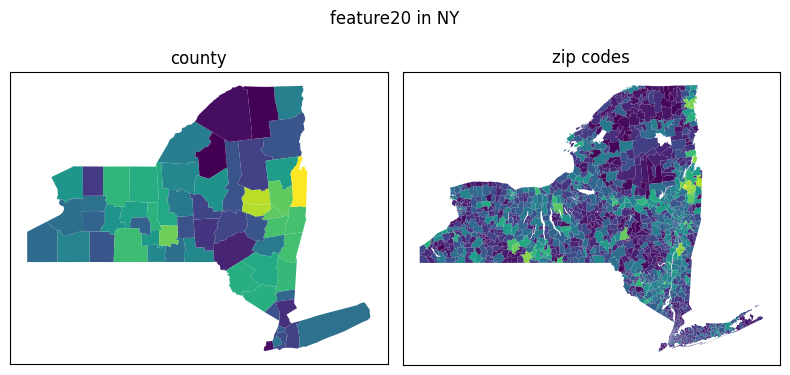

In [14]:
# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# County-level (DC has just one county equivalent)
county_data = get_locale(embeddings, county_embeddings.index, states=[state])
county_data.plot(feature, ax=ax[0])
ax[0].set(title='county')

# ZIP-level
zip_data = get_locale(embeddings, zip_embeddings.index, states=[state])
zip_data.plot(feature, ax=ax[1])
ax[1].set(title='zip codes')

# Title and formatting
fig.suptitle(f'{feature} in {state}')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()
plt.show()

### Let's get some Data Using DataCommons

In [16]:
labels = ['Count_Person',
          'Count_HousingUnit',
          'Count_Person_PerArea',
          'Median_Age_Person',
          'Median_Income_Household',
          'Percent_Person_WithAsthma',
          'Percent_Person_WithHighBloodPressure'
          ]
df_labels = dc.build_multivariate_dataframe(embeddings.index, labels)

In [17]:
df_labels.head(10)

,Count_HousingUnit,Median_Age_Person,Median_Income_Household,Percent_Person_WithAsthma,Percent_Person_WithHighBloodPressure,Count_Person
place,,,,,,
geoId/01001,24731,39.2,69841.0,10.0,40.6,59285
geoId/01003,128518,43.7,75019.0,9.7,38.7,239945
geoId/01005,11702,40.7,44290.0,11.2,48.9,24757
geoId/01007,9090,41.3,51215.0,10.7,42.3,22152
geoId/01009,24793,40.9,61096.0,10.5,40.5,59292
geoId/01011,4554,40.4,36723.0,11.9,52.4,10157
geoId/01013,9841,42.2,44881.0,11.2,47.7,18807
geoId/01015,53271,39.0,55826.0,10.2,41.3,116141
geoId/01017,16427,41.5,49295.0,11.4,46.8,34450


In [18]:
def evaluate(df: pd.DataFrame) -> dict:
    """Evaluates the model performance on the given dataframe.

    Args:
        df: A pandas DataFrame with columns 'y' and 'y_pred'.

    Returns:
        A dictionary of performance metrics.
    """
    if not {'y', 'y_pred'}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'y' and 'y_pred' columns")

    df = df.dropna(subset=['y', 'y_pred'])
    df = df[df['y'] != 0]

    r2 = skmetrics.r2_score(df['y'], df['y_pred'])
    correlation = df['y'].corr(df['y_pred'])
    rmse = math.sqrt(skmetrics.mean_squared_error(df['y'], df['y_pred']))
    mae = skmetrics.mean_absolute_error(df['y'], df['y_pred'])
    mape = skmetrics.mean_absolute_percentage_error(df['y'], df['y_pred'])

    return {'r2': r2, 'rmse': rmse, 'mae': mae, 'mape': mape, 'correlation': correlation}


def subset_eval(label: str, county_name: str, state: str, gpred: gpd.GeoDataFrame,
                visualize: bool = True, cmap: str = 'Greys') -> dict:
    """Runs intra-county or intra-state evaluation and visualizes the results.

    Args:
        label: The label for the title of the visualization.
        county_name: The specific county name to filter.
        state: The specific state name to filter.
        gpred: GeoDataFrame containing 'y', 'y_pred', 'state', and 'county' columns.
        visualize: Whether to display visualizations.
        cmap: Colormap for visualizations.

    Returns:
        A dictionary of performance metrics.
    """
    # Apply filters based on state and county name
    subset = gpred.copy()
    if state:
        subset = subset[subset['state'] == state]
    if county_name:
        subset = subset[subset['county'] == county_name]

    # Drop rows where 'y' is NaN
    subset = subset.dropna(subset=['y', 'y_pred'])
    eval_metrics = evaluate(subset)

    if visualize:
        _, ax = plt.subplots(1, 3, figsize=(12, 4))

        # Scatter plot of predicted vs actual
        subset.plot.scatter('y', 'y_pred', alpha=0.8, ax=ax[2], color='darkgray')
        x0, x1 = subset[['y', 'y_pred']].min().min(), subset[['y', 'y_pred']].max().max()
        ax[2].plot([x0, x1], [x0, x1], ls='--', color='black')
        ax[2].set_title(f'r={eval_metrics["correlation"]:.2f}, mae={eval_metrics["mae"]:.2f}')

        # Maps of actual and predicted values
        subset.plot('y', legend=True, ax=ax[0], vmin=x0, vmax=x1, cmap=cmap,
                    legend_kwds={'fraction': 0.02, 'pad': 0.05})
        ax[0].set_title('Actual')
        subset.plot('y_pred', legend=False, ax=ax[1], vmin=x0, vmax=x1, cmap=cmap)
        ax[1].set_title('Predicted')

        plt.setp(ax[:2], xticks=[], yticks=[])
        plt.suptitle(f'{label} - {county_name}, {state}')
        plt.tight_layout()

    return eval_metrics


def make_predictions_df(predictions: np.ndarray, test_df: gpd.GeoDataFrame, label: str) -> gpd.GeoDataFrame:
    """Creates a GeoDataFrame with predictions, true labels, and geographic info.

    Args:
        predictions: A sequence of predictions.
        test_df: The original test GeoDataFrame that the predictions are based on.
        label: The column name for the true label in `test_df`.

    Returns:
        A GeoDataFrame for evaluation and visualizations.
    """
    if label not in test_df.columns:
        raise ValueError(f"The specified label '{label}' does not exist in test_df columns.")

    df_predictions = pd.DataFrame({'y': test_df[label], 'y_pred': predictions}, index=test_df.index)
    return test_df[['geometry', 'Count_Person', 'state', 'county']].join(df_predictions)

In [19]:
def subset_eval_2(label: str, state: str, gpred: gpd.GeoDataFrame,
                  county_name: str = "", visualize: bool = True,
                  cmap: str = 'Blues') -> dict:
    """
    Evaluate and visualize predictions at ZIP level with residuals.

    Args:
        label: Name of the label variable (used for title).
        state: State abbreviation (e.g., 'DC', 'NY').
        gpred: GeoDataFrame with 'y', 'y_pred', 'state', 'county', and 'geometry'.
        county_name: Optional county filter (e.g., 'Kings County').
        visualize: Whether to show matplotlib plot.
        cmap: Matplotlib colormap.

    Returns:
        Dictionary of evaluation metrics.
    """
    # Subset data
    subset = gpred.copy()
    if state:
        subset = subset[subset['state'] == state]
    if county_name:
        subset = subset[subset['county'] == county_name]

    # Ensure valid data
    subset = subset.dropna(subset=['y', 'y_pred'])
    if subset.empty:
        print("No data to evaluate.")
        return {}

    # Compute residual
    subset['residual'] = subset['y'] - subset['y_pred']

    # Evaluate metrics
    eval_metrics = evaluate(subset)

    if visualize:
        fig, ax = plt.subplots(1, 3, figsize=(14, 5))

        # Actual
        subset.plot(column='y', legend=True, ax=ax[0], cmap=cmap,
                    legend_kwds={'label': 'Actual'}, edgecolor='none')
        ax[0].set_title("Actual")

        # Predicted
        subset.plot(column='y_pred', legend=True, ax=ax[1], cmap=cmap,
                    legend_kwds={'label': 'Predicted'}, edgecolor='none')
        ax[1].set_title("Predicted")

        # Residual
        subset.plot(column='residual', legend=True, ax=ax[2],
                    cmap='coolwarm', edgecolor='none',
                    legend_kwds={'label': 'Residual (y - y_pred)'})
        ax[2].set_title("Residuals")

        for axis in ax:
            axis.set_axis_off()

        fig.suptitle(f"{label} — ZIP-level: {county_name if county_name else state}")
        fig.tight_layout()

    return eval_metrics

#### Train On a Higher Scale and Test on a Lower Scale

In [21]:
df_labels.index

Index(['geoId/01001', 'geoId/01003', 'geoId/01005', 'geoId/01007',
       'geoId/01009', 'geoId/01011', 'geoId/01013', 'geoId/01015',
       'geoId/01017', 'geoId/01019',
       ...
       'zip/99357', 'zip/99359', 'zip/99360', 'zip/99361', 'zip/99362',
       'zip/99363', 'zip/99371', 'zip/99401', 'zip/99402', 'zip/99403'],
      dtype='object', name='place', length=35157)

In [37]:
df = embeddings.join(df_labels)

Let's choose one amongst - 
1. 'Count_Person',
2. 'Count_HousingUnit',
3. 'Median_Age_Person',
4. 'Median_Income_Household',
5. 'Percent_Person_WithAsthma',
6. 'Percent_Person_WithHighBloodPressure'

In [66]:
label = 'Count_Person'
data = df[df[label].notna() & (df.population > 500)]
train = data[data.index.isin(county_embeddings.index)]
test = data[data.index.isin(zip_embeddings.index)]

In [67]:
model = linear_model.Ridge()
model.fit(train[embedding_features], train[label])
predictions = model.predict(test[embedding_features])
gdf_predictions = make_predictions_df(predictions, test, label)
evaluate(gdf_predictions)

{'r2': -3336.839429005215,
 'rmse': 915413.6388756165,
 'mae': 418692.9851961826,
 'mape': 57.98030772691242,
 'correlation': 0.5248164726725281}

In [63]:
model = linear_model.Ridge()
model.fit(train[embedding_features], train[label])
predictions = model.predict(test[embedding_features])
gdf_predictions = make_predictions_df(predictions, test, label)
evaluate(gdf_predictions)

{'r2': 0.5391973671482921,
 'rmse': 0.8152573514699842,
 'mae': 0.5918204441024721,
 'mape': 0.05426134944568359,
 'correlation': 0.7710944059626152}

In [ ]:
gdf_predictions

,geometry,Count_Person,state,county,y,y_pred
place,,,,,,
zip/97910,"MULTIPOLYGON (((-117.12061 43.45986, -117.1205...",675,OR,Malheur County,675,5.845361e+04
zip/88030,"POLYGON ((-108.22990 32.23652, -108.22977 32.2...",24270,NM,Luna County,24270,8.582350e+04
zip/82633,"POLYGON ((-106.07824 43.47252, -106.07389 43.4...",9511,WY,Converse County,9511,5.626320e+04
zip/59538,"POLYGON ((-108.37115 47.79244, -108.37102 47.7...",2842,MT,Phillips County,2842,3.851445e+04
zip/89049,"MULTIPOLYGON (((-116.32932 37.86435, -116.3295...",2711,NV,Nye County,2711,-9.923615e+04
...,...,...,...,...,...,...
zip/10005,"POLYGON ((-74.01241 40.70676, -74.01120 40.706...",9238,NY,New York County,9238,-2.944232e+06
zip/10282,"POLYGON ((-74.01829 40.71354, -74.01735 40.713...",5960,NY,New York County,5960,1.205782e+06
zip/07311,"POLYGON ((-74.03391 40.71704, -74.03220 40.716...",1954,NJ,Hudson County,1954,1.106177e+06


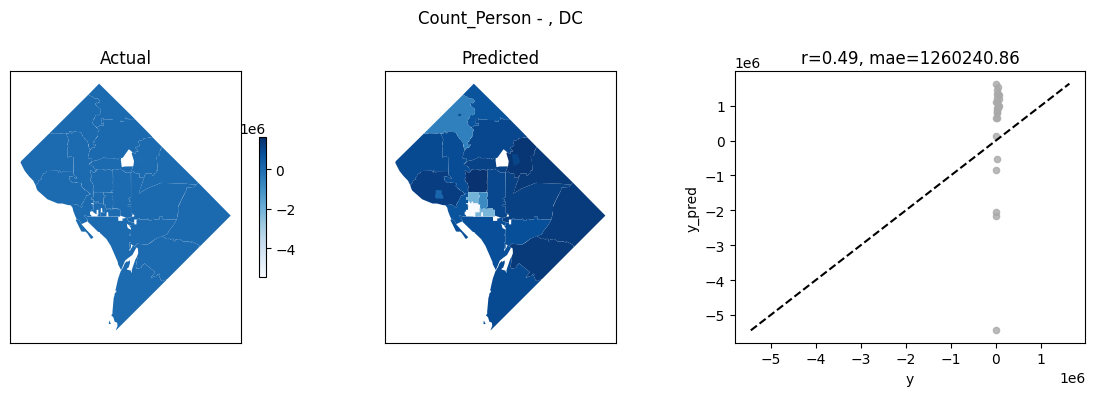

In [69]:
#@title Visualize some test set predictions
_ = subset_eval(label, '', 'DC', gdf_predictions, cmap='Blues')


Maybe we try to predict for a State!

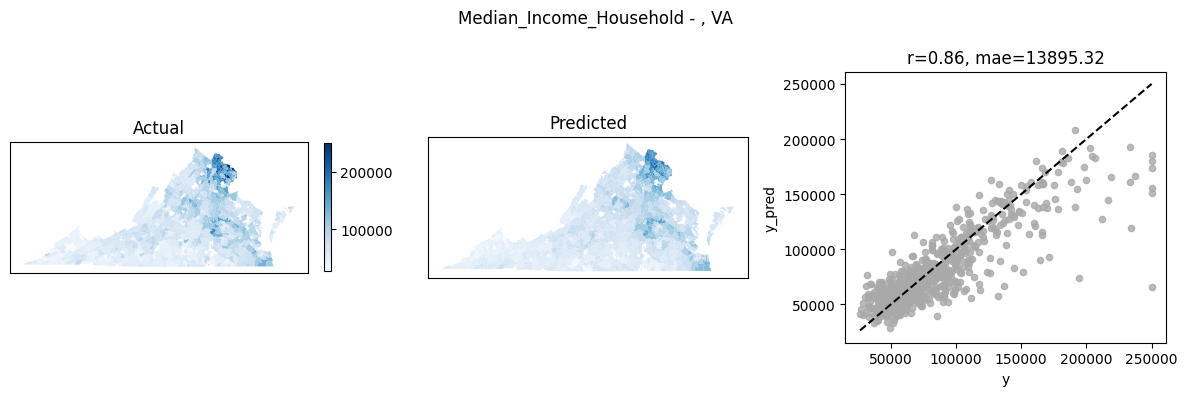

In [51]:
_ = subset_eval(label, '', 'VA', gdf_predictions, cmap='Blues')

In [57]:
train

,state,county,population,latitude,longitude,feature0,feature1,feature2,feature3,feature4,...,feature328,feature329,city,geometry,Percent_Person_WithAsthma,Percent_Person_WithHighBloodPressure,Count_Person,Count_HousingUnit,Median_Age_Person,Median_Income_Household
place,,,,,,,,,,,,,,,,,,,,,
geoId/01001,AL,Autauga County,58761,32.532237,-86.646439,-0.059204,1.153834,0.286746,0.324178,1.003599,...,-0.089127,4.831956,NaN,"POLYGON ((-86.91743 32.66417, -86.92120 32.656...",10.0,40.6,59285,24731,39.2,69841.0
geoId/01003,AL,Baldwin County,233420,30.659218,-87.746067,-0.089298,0.710666,0.358453,1.138983,2.012795,...,-0.128016,4.151655,NaN,"MULTIPOLYGON (((-87.44728 30.51503, -87.44562 ...",9.7,38.7,239945,128518,43.7,75019.0
geoId/01005,AL,Barbour County,24877,31.870253,-85.405103,-0.089458,1.756277,0.749515,0.796651,0.555815,...,-0.147867,0.032731,NaN,"POLYGON ((-85.74827 31.61803, -85.54881 31.618...",11.2,48.9,24757,11702,40.7,44290.0
geoId/01007,AL,Bibb County,22251,33.015893,-87.127148,-0.117877,0.725561,0.436291,0.307150,1.347822,...,-0.028330,4.688914,NaN,"POLYGON ((-87.42192 33.00340, -87.42075 32.884...",10.7,42.3,22152,9090,41.3,51215.0
geoId/01009,AL,Blount County,59077,33.977357,-86.566440,-0.133150,0.648858,0.592053,0.382824,1.486730,...,-0.045479,3.491446,NaN,"POLYGON ((-86.96227 33.85816, -86.96294 33.844...",10.5,40.5,59292,24793,40.9,61096.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
geoId/56037,WY,Sweetwater County,42079,41.660328,-108.875677,-0.063610,0.934990,0.400831,0.443420,1.147422,...,-0.002064,4.597163,NaN,"POLYGON ((-110.05441 42.00717, -110.04642 42.0...",10.6,30.5,41786,19226,37.4,76464.0
geoId/56039,WY,Teton County,23346,44.048662,-110.426075,-0.094174,1.141469,1.828613,1.950659,1.302107,...,-0.005167,3.825687,NaN,"POLYGON ((-111.05346 44.66628, -111.05243 44.4...",8.9,26.1,23358,13503,40.1,112681.0
geoId/56041,WY,Uinta County,20546,41.284726,-110.558947,-0.084327,1.105458,2.132980,0.434162,1.792016,...,-0.010434,2.912843,NaN,"POLYGON ((-111.04601 40.99788, -110.51873 40.9...",10.6,31.1,20605,8868,36.7,82672.0


In [52]:
test

,state,county,population,latitude,longitude,feature0,feature1,feature2,feature3,feature4,...,feature328,feature329,city,geometry,Percent_Person_WithAsthma,Percent_Person_WithHighBloodPressure,Count_Person,Count_HousingUnit,Median_Age_Person,Median_Income_Household
place,,,,,,,,,,,,,,,,,,,,,
zip/97910,OR,Malheur County,609,42.749076,-117.511459,-0.138227,1.120377,0.072900,0.297442,0.772673,...,-1.010470e-03,4.495589,Jordan Valley,"MULTIPOLYGON (((-117.12061 43.45986, -117.1205...",12.2,39.9,675,380,39.2,68472.0
zip/88030,NM,Luna County,24139,32.191634,-107.729431,-0.046666,1.414424,0.146803,1.113256,1.119576,...,-5.116325e-02,3.866543,Deming,"POLYGON ((-108.22990 32.23652, -108.22977 32.2...",11.6,40.2,24270,10812,36.5,39514.0
zip/82633,WY,Converse County,9478,43.022270,-105.410250,-0.090293,1.266280,0.447868,0.781861,1.731813,...,-4.237000e-05,7.453567,Douglas,"POLYGON ((-106.07824 43.47252, -106.07389 43.4...",10.7,32.2,9511,4653,39.9,81467.0
zip/59538,MT,Phillips County,2936,48.112019,-107.845520,-0.092886,1.256203,-0.050897,0.321954,1.281864,...,-1.086910e-03,0.972243,Malta,"POLYGON ((-108.37115 47.79244, -108.37102 47.7...",11.3,35.1,2842,1363,44.0,65833.0
zip/89049,NV,Nye County,2496,38.356663,-116.262314,-0.102206,1.363530,0.950862,1.027124,1.063400,...,-4.612896e-02,2.907423,Tonopah,"MULTIPOLYGON (((-116.32932 37.86435, -116.3295...",11.6,36.5,2711,1601,53.6,36570.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zip/10005,NY,New York County,8637,40.705974,-74.008768,-0.142861,0.778521,3.640563,1.774548,0.103140,...,-0.000000e+00,3.934241,New York,"POLYGON ((-74.01241 40.70676, -74.01120 40.706...",8.3,11.5,9238,6495,31.5,211810.0
zip/10282,NY,New York County,6419,40.716651,-74.015375,-0.100264,0.735064,2.936799,1.325595,0.061965,...,-0.000000e+00,4.027349,New York,"POLYGON ((-74.01829 40.71354, -74.01735 40.713...",8.2,18.4,5960,2950,39.4,250000.0
zip/07311,NJ,Hudson County,1494,40.720216,-74.032724,-0.089607,0.725118,2.595540,1.204948,0.335804,...,-0.000000e+00,-0.001507,Jersey City,"POLYGON ((-74.03391 40.71704, -74.03220 40.716...",7.1,12.0,1954,1284,30.2,179928.0


{'r2': -5602.892693577457,
 'rmse': 1584228.815861429,
 'mae': 1260240.855905584,
 'mape': 321.6228851186638,
 'correlation': 0.4875801174044944}

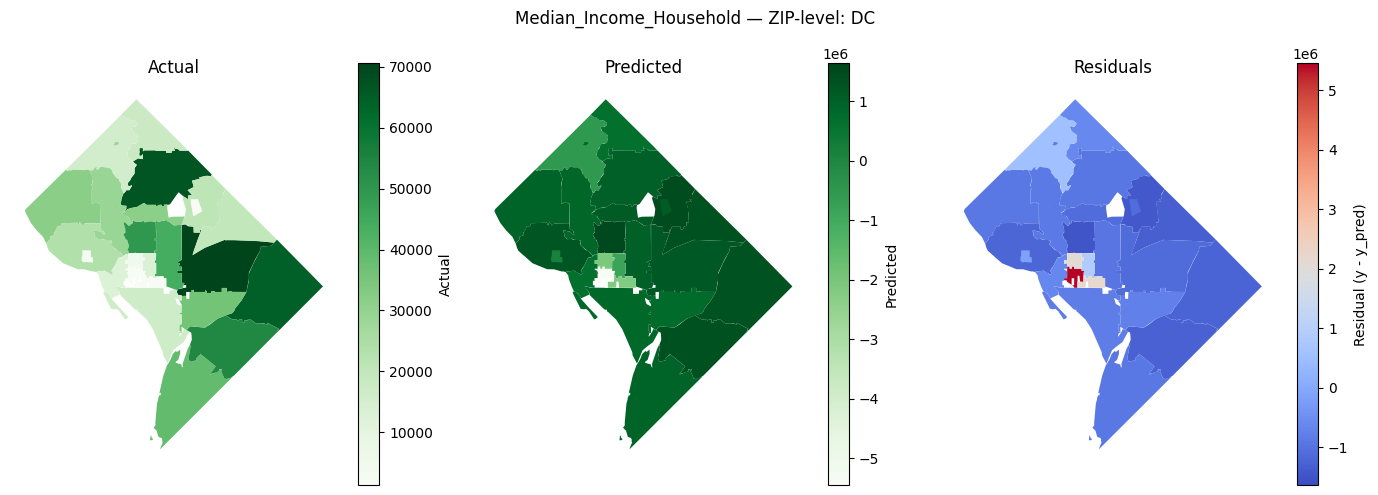

In [70]:
subset_eval_2(label='Median_Income_Household', state='DC', gpred=gdf_predictions, county_name="", cmap='Greens')